In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna


In [22]:
# Cargar el dataset
data = pd.read_csv('electricity-consumption-processed.csv', sep=';', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

# Verificar los datos
print(data.head())

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000


In [23]:
# Cargar covariantes
covariates = pd.read_csv('meteorological-processed.csv', sep=';', parse_dates=['datetime'])
covariates.set_index('datetime', inplace=True)
# Verificar los datos de las covariantes
print(covariates.head())

                     temperature   humidity  wind_speed    pressure
datetime                                                           
2017-01-01 00:00:00    26.000000  85.000000    9.300000  982.500000
2017-01-01 01:00:00    25.666667  88.000000    8.666667  982.266667
2017-01-01 02:00:00    25.333333  91.000000    8.033333  982.033333
2017-01-01 03:00:00    25.000000  94.000000    7.400000  981.800000
2017-01-01 04:00:00    24.000000  93.333333    9.866667  981.633333


In [24]:
# Filtrar datos por subestación y alimentador, si es necesario
substation = 'A'  # Cambia según tu dataset
feeder = 'A1'      # Cambia según tu dataset
data_filtered = data[(data['substation'] == substation) & (data['feeder'] == feeder)]

In [25]:
# Definir el mes específico que quieres filtrar
start_date = '2019-01-01'
end_date = '2020-06-30'

# Filtrar los datos históricos y las predicciones
data_filtered= data_filtered[start_date:end_date]


In [26]:
# Agrupar por día y calcular el consumo máximo
daily_max_consumption = data_filtered.groupby(data_filtered.index.date)['consumption'].max().reset_index()
daily_max_consumption.columns = ['date', 'max_consumption']
daily_max_consumption.set_index('date', inplace=True)
print(daily_max_consumption)
# Agrupar las covariantes por día, usando la media como ejemplo
daily_covariates = covariates.groupby(covariates.index.date).mean()
daily_covariates.index = pd.to_datetime(daily_covariates.index)
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)
#del daily_covariates['humidity']
print(daily_covariates)


            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-06-26       106.000000
2020-06-27       111.000000
2020-06-28       111.000000
2020-06-29       104.000000
2020-06-30        98.000000

[547 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2019-01-01    29.525000  70.895833   11.958333  981.243750
2019-01-02    27.733333  82.000000   10.050000  982.591667
2019-01-03    29.116667  75.750000   15.000000  981.291667
2019-01-04    27.412500  80.250000    9.708333  981.454167
2019-01-05    26.283333  80.875000    6.958333  982.137500
...                 ...        ...         ...         ...
2020-06-26    11.691667  78.750000   13.000000  988.654167
2020-06-27    13.329167  74.979167   11.437500  987.127083
2020-06-28    14.50277

In [27]:
# Asegúrate de que ambos DataFrames tienen índices alineados
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)

# Verifica si hay valores nulos después de la alineación
print(daily_covariates.isna().sum())

#Rellena valores nulos si es necesario
daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption)
print(daily_covariates)

temperature    0
humidity       0
wind_speed     0
pressure       0
dtype: int64
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-06-26       106.000000
2020-06-27       111.000000
2020-06-28       111.000000
2020-06-29       104.000000
2020-06-30        98.000000

[547 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2019-01-01    29.525000  70.895833   11.958333  981.243750
2019-01-02    27.733333  82.000000   10.050000  982.591667
2019-01-03    29.116667  75.750000   15.000000  981.291667
2019-01-04    27.412500  80.250000    9.708333  981.454167
2019-01-05    26.283333  80.875000    6.958333  982.137500
...                 ...        ...         ...         ...
2020-06-26    11.691667  78.750000   13.000000  988.654167


C:\Users\loku7\AppData\Local\Temp\ipykernel_16008\2860517806.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')


In [28]:
# %%
# Asegurarte de que el índice sea de frecuencia diaria

daily_covariates = daily_covariates.dropna()
daily_max_consumption = daily_max_consumption.asfreq('D')
daily_covariates = daily_covariates.asfreq('D')
#Rellena valores nulos si es necesario
daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption.index.freq)
print(daily_covariates.index.freq) 
print(daily_max_consumption)
print(daily_covariates)

<Day>
<Day>
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-06-26       106.000000
2020-06-27       111.000000
2020-06-28       111.000000
2020-06-29       104.000000
2020-06-30        98.000000

[547 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2019-01-01    29.525000  70.895833   11.958333  981.243750
2019-01-02    27.733333  82.000000   10.050000  982.591667
2019-01-03    29.116667  75.750000   15.000000  981.291667
2019-01-04    27.412500  80.250000    9.708333  981.454167
2019-01-05    26.283333  80.875000    6.958333  982.137500
...                 ...        ...         ...         ...
2020-06-26    11.691667  78.750000   13.000000  988.654167
2020-06-27    13.329167  74.979167   11.437500  987.127083
2020-06-28

C:\Users\loku7\AppData\Local\Temp\ipykernel_16008\2144682794.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')


In [29]:
# Función objetivo para Optuna
def objective(trial):
    p = trial.suggest_int("p", 0, 10)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 10)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    m = trial.suggest_int("m", 7, 30)  # Período estacional entre semanal y mensual

    try:
        # Ajustar el modelo SARIMAX
        model = SARIMAX(
            daily_max_consumption['max_consumption'],
            exog=daily_covariates,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m)
        )
        results = model.fit(disp=False)

        # Realizar predicciones dentro del conjunto de datos
        pred = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1], exog=daily_covariates)
        pred_mean = pred.predicted_mean

        # Calcular el error cuadrático medio
        mse = mean_squared_error(daily_max_consumption['max_consumption'], pred_mean)
        return mse
    except Exception:
        return float('inf')  # Penalizar combinaciones que no funcionen


In [30]:
# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, n_jobs=-1)  # Número de pruebas

# Resultados de la optimización
print("Mejores parámetros:", study.best_params)
print("Mejor MSE:", study.best_value)

[I 2024-11-25 23:07:29,152] A new study created in memory with name: no-name-36c8ac4f-cb9d-4a61-8843-27020018195f
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
[I 2024-11-25 23:08:07,196] Trial 5 finished with value: 117.00527965054114 and parameters: {'p': 0, 'd': 1, 'q': 9, 'P': 0, 'D': 0, 'Q': 1, 'm': 11}. Best is trial 5 with value: 117.00527965054114.
[I 2024-11

Mejores parámetros: {'p': 3, 'd': 0, 'q': 10, 'P': 2, 'D': 0, 'Q': 2, 'm': 11}
Mejor MSE: 59.33219611311006


In [31]:
# Usar los mejores parámetros para ajustar el modelo final
best_params = study.best_params
model = SARIMAX(
    daily_max_consumption['max_consumption'],
    exog=daily_covariates,
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m'])
)
results = model.fit()



C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
# %%
# Predicciones
forecast = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1], exog=daily_covariates)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [33]:
# %%
# Calcular métricas finales
mae = mean_absolute_error(daily_max_consumption['max_consumption'], pred_mean)
rmse = np.sqrt(mean_squared_error(daily_max_consumption['max_consumption'], pred_mean))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 5.81, RMSE: 7.70


In [34]:
# %% Predicción para la subestación B y alimentador B1
substation2 = 'B'  # Subestación B
feeder2 = 'B1'     # Alimentador B1

# Filtrar los datos por subestación y alimentador
data_filtered2 = data[(data['substation'] == substation2) & (data['feeder'] == feeder2)]
data_filtered2 = data_filtered2[start_date:end_date]

# Agrupar por día y calcular el consumo máximo para la subestación B1
daily_max_consumption2 = data_filtered2.groupby(data_filtered2.index.date)['consumption'].max().reset_index()
daily_max_consumption2.columns = ['date', 'max_consumption']
daily_max_consumption2.set_index('date', inplace=True)

# Asegurar que las covariantes están alineadas con el índice de la subestación B1
daily_covariates2 = daily_covariates.reindex(daily_max_consumption2.index)

# Rellenar valores nulos si es necesario
daily_max_consumption2 = daily_max_consumption2.fillna(method='ffill').fillna(method='bfill')
daily_covariates2 = daily_covariates2.fillna(method='ffill').fillna(method='bfill')
# Asegurar que los índices sean del tipo pd.Timestamp
daily_max_consumption2.index = pd.to_datetime(daily_max_consumption2.index)
daily_covariates2.index = pd.to_datetime(daily_covariates2.index)


def objective_b2(trial):
    p = trial.suggest_int("p", 0, 10)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 10)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    m = trial.suggest_int("m", 7, 30)  # Período estacional entre semanal y mensual

    try:
        # Ajustar el modelo SARIMAX con los datos de la subestación B1
        model = SARIMAX(
            daily_max_consumption2['max_consumption'],
            exog=daily_covariates2,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m)
        )
        results = model.fit(disp=False)

        # Realizar predicciones dentro del conjunto de datos
        pred = results.get_prediction(
            start=daily_max_consumption2.index[0],
            end=daily_max_consumption2.index[-1],
            exog=daily_covariates2
        )
        pred_mean = pred.predicted_mean

        # Calcular el error cuadrático medio
        mse = mean_squared_error(daily_max_consumption2['max_consumption'], pred_mean)
        return mse
    except Exception:
        return float('inf')  # Penalizar combinaciones que no funcionen
    # Crear un estudio para la subestación B2
study_b2 = optuna.create_study(direction="minimize")
study_b2.optimize(objective_b2, n_trials=20, n_jobs=-1)  # Ajusta n_trials según sea necesario

# Resultados de la optimización
print("Mejores parámetros para B2:", study_b2.best_params)
print("Mejor MSE para B2:", study_b2.best_value)
best_params_b2 = study_b2.best_params
model_b2 = SARIMAX(
    daily_max_consumption2['max_consumption'],
    exog=daily_covariates2,
    order=(best_params_b2['p'], best_params_b2['d'], best_params_b2['q']),
    seasonal_order=(best_params_b2['P'], best_params_b2['D'], best_params_b2['Q'], best_params_b2['m'])
)
results_b2 = model_b2.fit()
forecast_b2 = results_b2.get_prediction(
    start=daily_max_consumption2.index[0],
    end=daily_max_consumption2.index[-1],
    exog=daily_covariates2
)
pred_mean_b2 = forecast_b2.predicted_mean
conf_int_b2 = forecast_b2.conf_int()

# Calcular métricas finales
mae_b2 = mean_absolute_error(daily_max_consumption2['max_consumption'], pred_mean_b2)
rmse_b2 = np.sqrt(mean_squared_error(daily_max_consumption2['max_consumption'], pred_mean_b2))
print(f"MAE para B2: {mae_b2:.2f}, RMSE para B2: {rmse_b2:.2f}")

C:\Users\loku7\AppData\Local\Temp\ipykernel_16008\3943908149.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption2 = daily_max_consumption2.fillna(method='ffill').fillna(method='bfill')
C:\Users\loku7\AppData\Local\Temp\ipykernel_16008\3943908149.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates2 = daily_covariates2.fillna(method='ffill').fillna(method='bfill')
[I 2024-11-25 23:26:14,588] A new study created in memory with name: no-name-3e54ecbf-ebe9-4dfd-9f4a-c589219b1ed1
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, f

Mejores parámetros para B2: {'p': 6, 'd': 2, 'q': 9, 'P': 1, 'D': 0, 'Q': 0, 'm': 20}
Mejor MSE para B2: 745.4611542498072


C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE para B2: 19.29, RMSE para B2: 27.30


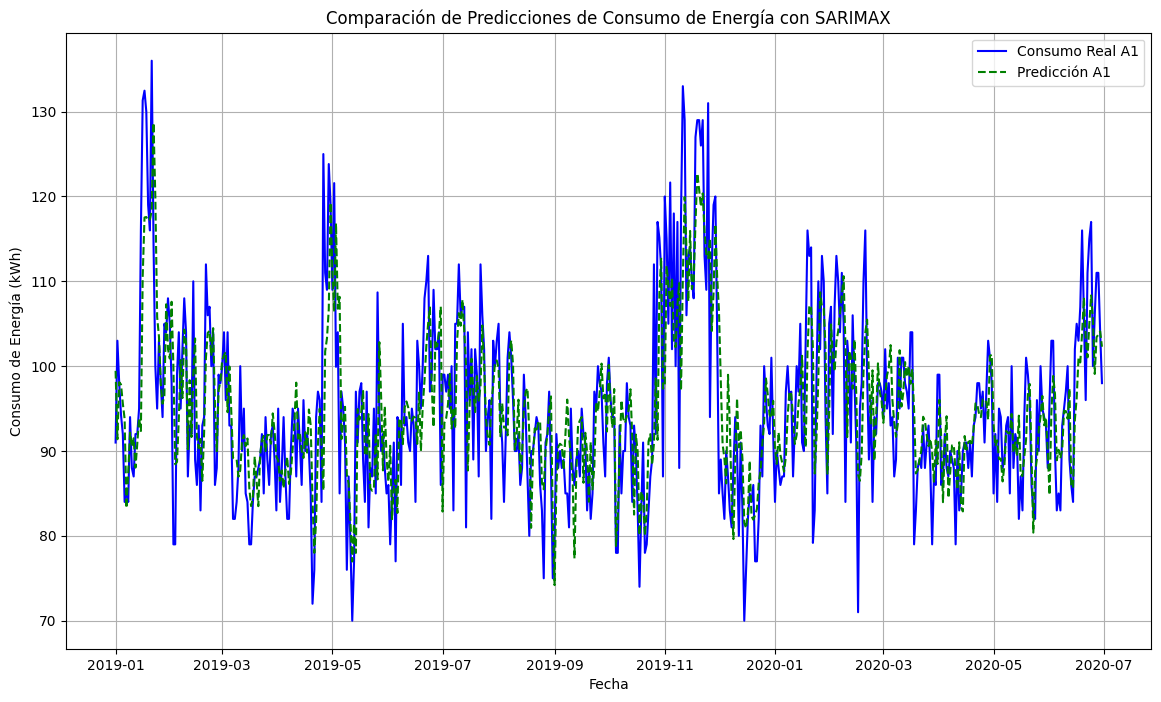

In [35]:

# %% Gráfico comparativo
plt.figure(figsize=(14, 8))

# Gráfico para la subestación A1
plt.plot(daily_max_consumption.index, daily_max_consumption['max_consumption'], label='Consumo Real A1', color='blue')
plt.plot(pred_mean.index, pred_mean, label='Predicción A1', linestyle='--', color='green')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía (kWh)')
plt.title('Comparación de Predicciones de Consumo de Energía con SARIMAX')
plt.legend()
plt.grid()
plt.show()

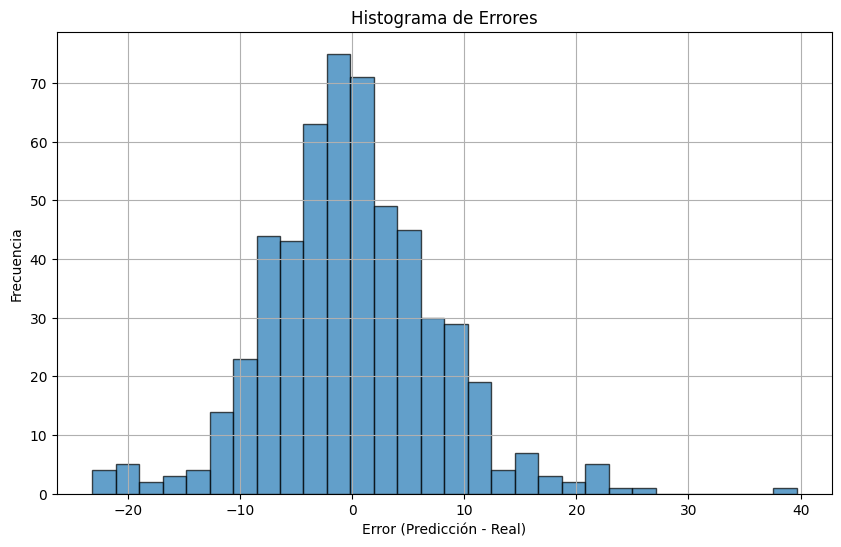

In [36]:
errors = daily_max_consumption['max_consumption'] - pred_mean

# Crear el histograma de los errores
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histograma de Errores')
plt.xlabel('Error (Predicción - Real)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

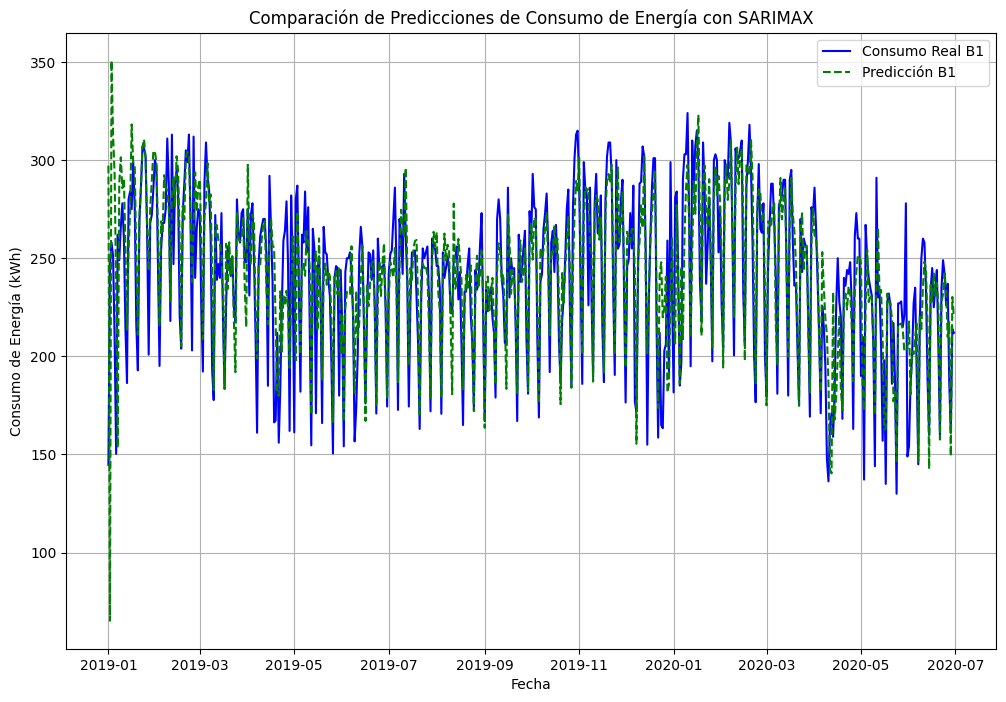

In [37]:
# Graficar las predicciones para la subestación B2
plt.figure(figsize=(12, 8))
plt.plot(daily_max_consumption2, label='Consumo Real B1', color='blue')
plt.plot(pred_mean_b2, color='green', linestyle='--', label='Predicción B1')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía (kWh)')
plt.title('Comparación de Predicciones de Consumo de Energía con SARIMAX')
plt.legend()
plt.grid()
plt.show()

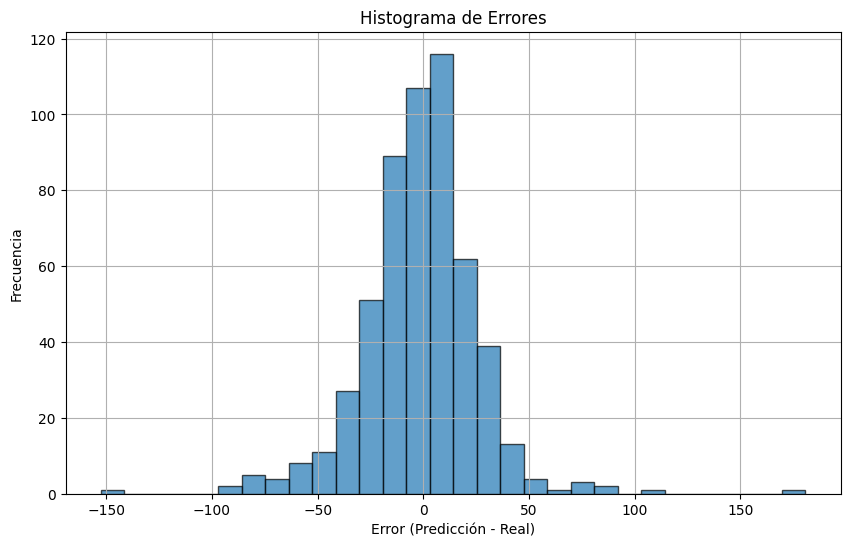

In [38]:
errors2 = daily_max_consumption2['max_consumption'] - pred_mean_b2

# Crear el histograma de los errores
plt.figure(figsize=(10, 6))
plt.hist(errors2, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histograma de Errores')
plt.xlabel('Error (Predicción - Real)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()